# Poisson Causal Discovery Example

This notebook demonstrates causal network discovery using the **Poisson** information method with synthetic count data.

## Overview
- Generate synthetic Poisson time series with known causal structure
- Visualize the count dynamics and network structure
- Apply causal discovery using Poisson conditional mutual information
- Evaluate performance using ROC-AUC metric

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Import causal discovery components
from causationentropy.core.discovery import discover_network
from causationentropy.datasets.synthetic import poisson_coupled_oscillators

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Create Ground Truth Network

We'll create a directed graph that represents the true causal relationships for our Poisson process.

In [2]:
# Create a ground truth network
n_nodes = 6
seed = 42

# Create a network with interesting structure for Poisson processes
np.random.seed(seed)
G_true = nx.DiGraph()
G_true.add_nodes_from(range(n_nodes))

# Add causal edges that create interesting count dynamics
edges = [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5)]
G_true.add_edges_from(edges)

print(f"Ground truth network has {G_true.number_of_nodes()} nodes and {G_true.number_of_edges()} edges")
print(f"Edges: {list(G_true.edges())}")

# Get adjacency matrix for later comparison
A_true = nx.adjacency_matrix(G_true).toarray()
print(f"\nGround truth adjacency matrix:")
print(A_true)

Ground truth network has 6 nodes and 6 edges
Edges: [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5)]

Ground truth adjacency matrix:
[[0 1 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]]


## 2. Generate Synthetic Poisson Time Series

Generate count data where each node's rate depends on its neighbors' previous counts.

In [3]:
# Generate synthetic Poisson time series
T = 200  # Time series length
lambda_base = 3.0  # Base Poisson rate
coupling_strength = 0.5  # How much neighbors influence the rate

# Generate data using our custom Poisson generator
data, A_generated = poisson_coupled_oscillators(
    n=n_nodes,
    T=T,
    G=G_true,  # Use our predefined network
    lambda_base=lambda_base,
    coupling_strength=coupling_strength,
    seed=seed
)

print(f"Generated Poisson time series data with shape: {data.shape}")
print(f"Data statistics:")
print(f"  Mean: {np.mean(data):.3f}")
print(f"  Std:  {np.std(data):.3f}")
print(f"  Range: [{np.min(data):.0f}, {np.max(data):.0f}]")
print(f"  Data type: {data.dtype} (discrete counts)")

# Verify that generated adjacency matches our ground truth
print(f"\nAdjacency matrix match: {np.array_equal(A_true, A_generated.astype(int))}")

Generated Poisson time series data with shape: (200, 6)
Data statistics:
  Mean: 4.963
  Std:  3.007
  Range: [0, 19]
  Data type: float64 (discrete counts)

Adjacency matrix match: True


## 3. Visualize Poisson Time Series Data

Plot the count dynamics to understand the characteristics of Poisson data.

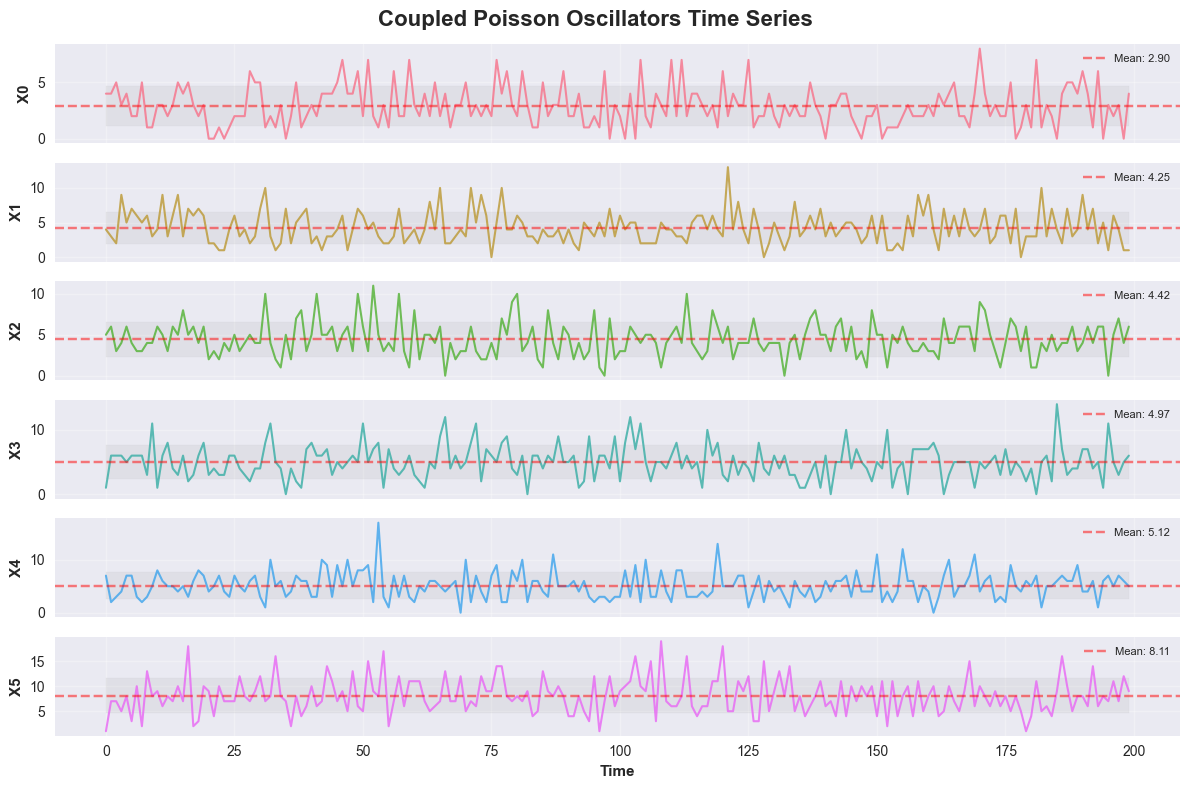

In [5]:
# Plot time series for all variables
fig, axes = plt.subplots(n_nodes, 1, figsize=(12, 8), sharex=True)
fig.suptitle('Coupled Poisson Oscillators Time Series', fontsize=16, fontweight='bold')

time = np.arange(T)
colors = sns.color_palette("husl", n_nodes)

for i in range(n_nodes):
    axes[i].plot(time, data[:, i], color=colors[i], alpha=0.8, linewidth=1.5)
    axes[i].set_ylabel(f'X{i}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    
    # Highlight the time series statistics
    mean_val = np.mean(data[:, i])
    std_val = np.std(data[:, i])
    axes[i].axhline(mean_val, color='red', linestyle='--', alpha=0.5, label=f'Mean: {mean_val:.2f}')
    axes[i].fill_between(time, mean_val-std_val, mean_val+std_val, alpha=0.1, color='gray')
    axes[i].legend(fontsize=8)

axes[-1].set_xlabel('Time', fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Visualize Ground Truth Network

Display the true causal network structure that generates the count dynamics.

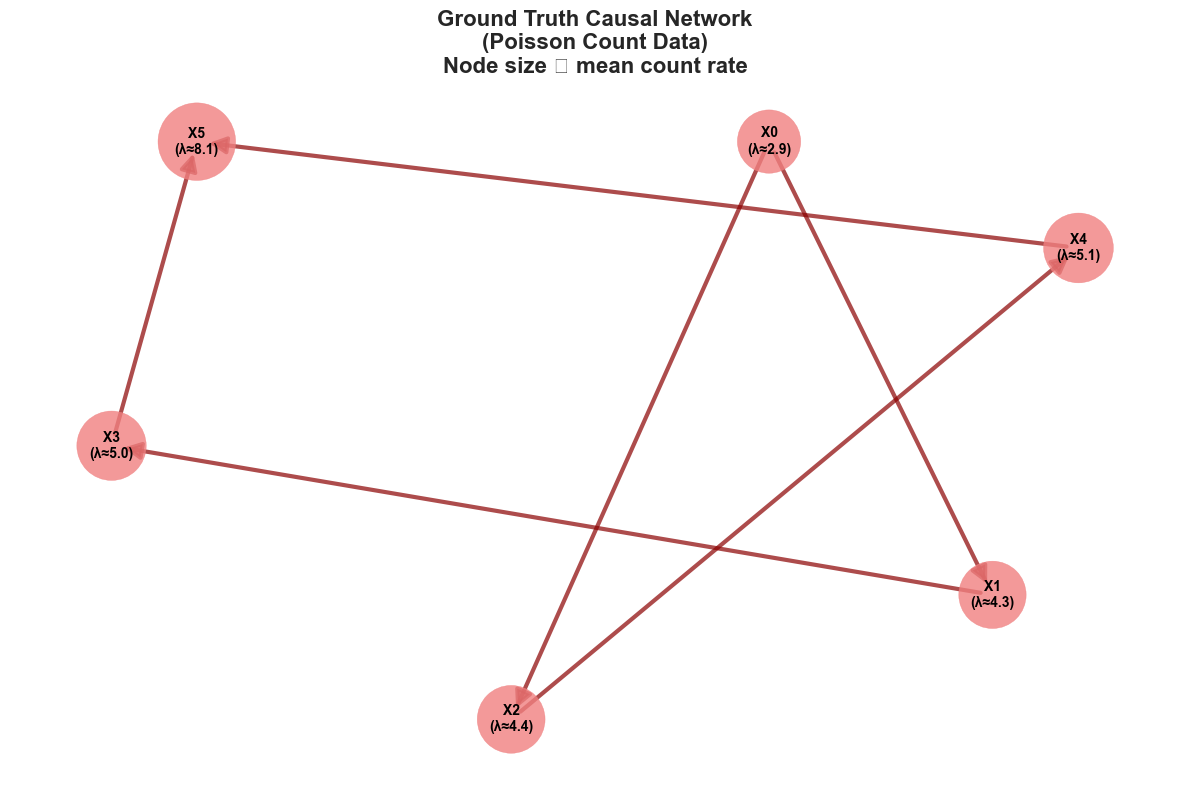

Ground Truth Network Statistics:
  Nodes: 6
  Edges: 6
  Edge density: 0.200
  Is DAG: True
  Average count rates: ['X0: 2.9', 'X1: 4.3', 'X2: 4.4', 'X3: 5.0', 'X4: 5.1', 'X5: 8.1']


In [15]:
# Plot ground truth network
plt.figure(figsize=(12, 8))

# Create layout that shows the flow structure
pos = nx.spring_layout(G_true, seed=seed, k=3, iterations=50)

# Draw network with emphasis on count-based coupling
node_sizes = [1500 + 200 * np.mean(data[:, i]) for i in range(n_nodes)]
nx.draw_networkx_nodes(G_true, pos, node_color='lightcoral', 
                       node_size=node_sizes, alpha=0.8)
nx.draw_networkx_edges(G_true, pos, edge_color='darkred', 
                       arrows=True, arrowsize=25, width=3, alpha=0.7)
nx.draw_networkx_labels(G_true, pos, {i: f'X{i}\n(λ≈{np.mean(data[:, i]):.1f})' for i in range(n_nodes)},
                        font_size=10, font_weight='bold')

plt.title('Ground Truth Causal Network\n(Poisson Count Data)\nNode size ∝ mean count rate', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print network statistics
print("Ground Truth Network Statistics:")
print(f"  Nodes: {G_true.number_of_nodes()}")
print(f"  Edges: {G_true.number_of_edges()}")
print(f"  Edge density: {nx.density(G_true):.3f}")
print(f"  Is DAG: {nx.is_directed_acyclic_graph(G_true)}")
print(f"  Average count rates: {[f'X{i}: {np.mean(data[:, i]):.1f}' for i in range(n_nodes)]}")

## 5. Apply Causal Discovery with Poisson Method

Use the Poisson information method to discover causal relationships from the count data.

In [17]:
# Apply causal discovery with Poisson method
print("Applying causal discovery with Poisson information method...")
print("This method is specifically designed for count data!\n")

# Test different discovery methods with Poisson information
methods_to_test = ['standard', 'alternative']
discovered_networks = {}

for method in methods_to_test:
    print(f"Running {method} method with Poisson information...")
    
    G_discovered = discover_network(
        data=data,
        method=method,
        information='poisson',  # Key: Use Poisson-specific information measure
        max_lag=2,
        alpha_forward=0.1,  # Slightly more lenient for count data
        alpha_backward=0.1,
        n_shuffles=100
    )
    
    discovered_networks[method] = G_discovered
    print(f"  Discovered {G_discovered.number_of_edges()} edges")
    print(f"  Edges: {list(G_discovered.edges())}\n")

Applying causal discovery with Poisson information method...
This method is specifically designed for count data!

Running standard method with Poisson information...
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 5 (X5)
  Discovered 8 edges
  Edges: [('X0', 'X1'), ('X0', 'X2'), ('X1', 'X3'), ('X2', 'X4'), ('X3', 'X5'), ('X4', 'X0'), ('X4', 'X5'), ('X5', 'X4')]

Running alternative method with Poisson information...
Estimating edges for node 0 (X0)
Estimating edges for node 1 (X1)
Estimating edges for node 2 (X2)
Estimating edges for node 3 (X3)
Estimating edges for node 4 (X4)
Estimating edges for node 5 (X5)
  Discovered 12 edges
  Edges: [('X0', 'X1'), ('X0', 'X2'), ('X1', 'X3'), ('X2', 'X0'), ('X2', 'X3'), ('X2', 'X4'), ('X3', 'X5'), ('X4', 'X5'), ('X5', 'X0'), ('X5', 'X0'), ('X5', 'X2'), ('X5', 'X4')]



## 6. Visualize Discovered Networks

Compare the discovered networks with the ground truth.

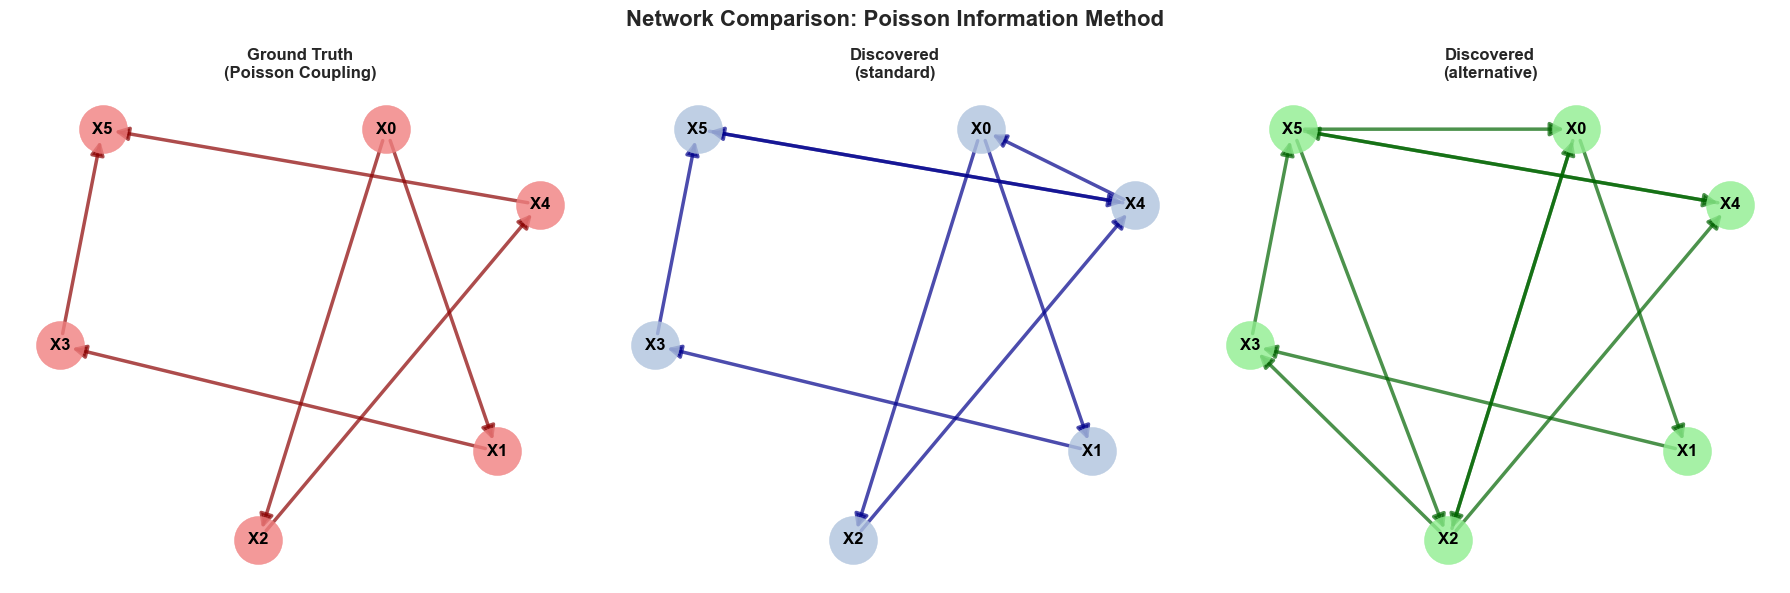

EDGE COMPARISON:
Ground Truth Edges: {(0, 1), (2, 4), (0, 2), (4, 5), (1, 3), (3, 5)}
Standard Discovered: {(0, 1), (2, 4), (4, 0), (5, 4), (0, 2), (4, 5), (1, 3), (3, 5)}
Correct: {(0, 1), (2, 4), (4, 5), (0, 2), (1, 3), (3, 5)}
Missed: set()
False Pos: {(5, 4), (4, 0)}
Alternative Discovered: {(0, 1), (2, 4), (5, 4), (2, 0), (2, 3), (0, 2), (4, 5), (5, 0), (1, 3), (3, 5), (5, 2)}
Correct: {(0, 1), (2, 4), (4, 5), (0, 2), (1, 3), (3, 5)}
Missed: set()
False Pos: {(5, 4), (2, 0), (2, 3), (5, 0), (5, 2)}


In [23]:
# Plot comparison of networks
fig, axes = plt.subplots(1, len(methods_to_test) + 1, figsize=(6 * (len(methods_to_test) + 1), 6))
if len(methods_to_test) == 1:
    axes = [axes[0], axes[1]]

# Plot ground truth
ax = axes[0]
nx.draw_networkx_nodes(G_true, pos, node_color='lightcoral', 
                       node_size=1200, alpha=0.8, ax=ax)
nx.draw_networkx_edges(G_true, pos, edge_color='darkred', 
                       arrows=True, arrowsize=20, width=2.5, alpha=0.7, ax=ax)
nx.draw_networkx_labels(G_true, pos, {i: f'X{i}' for i in range(n_nodes)},
                        font_size=12, font_weight='bold', ax=ax)
ax.set_title('Ground Truth\n(Poisson Coupling)', fontweight='bold')
ax.axis('off')

# Plot discovered networks
colors = ['lightsteelblue', 'lightgreen']
edge_colors = ['darkblue', 'darkgreen']

for i, (method, G_disc) in enumerate(discovered_networks.items()):
    ax = axes[i + 1]
    
    # Convert node names back to integers
    G_disc_int = nx.DiGraph()
    G_disc_int.add_nodes_from(range(n_nodes))
    for edge in G_disc.edges():
        src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])
        dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])
        G_disc_int.add_edge(src, dst)
    
    nx.draw_networkx_nodes(G_disc_int, pos, node_color=colors[i], 
                           node_size=1200, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G_disc_int, pos, edge_color=edge_colors[i], 
                           arrows=True, arrowsize=20, width=2.5, alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G_disc_int, pos, {i: f'X{i}' for i in range(n_nodes)},
                            font_size=12, font_weight='bold', ax=ax)
    ax.set_title(f'Discovered\n({method})', fontweight='bold')
    ax.axis('off')

plt.suptitle('Network Comparison: Poisson Information Method', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show edge comparison table
print("EDGE COMPARISON:")
true_edges = set(G_true.edges())
print(f"Ground Truth Edges: {true_edges}")

for method, G_disc in discovered_networks.items():
    # Convert discovered edges to integer format
    disc_edges = set()
    for edge in G_disc.edges():
        src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])
        dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])
        disc_edges.add((src, dst))
    
    print(f"{method.capitalize()} Discovered: {disc_edges}")
    
    # Calculate overlap
    correct = true_edges.intersection(disc_edges)
    missed = true_edges - disc_edges
    false_positive = disc_edges - true_edges
    
    print(f"Correct: {correct}")
    print(f"Missed: {missed}")
    print(f"False Pos: {false_positive}")

## 7. Calculate ROC-AUC Performance

Evaluate the performance of the Poisson method using ROC-AUC score.

STANDARD METHOD (Poisson Information):
  ROC-AUC Score: 0.958
  Interpretation: Excellent
ALTERNATIVE METHOD (Poisson Information):
  ROC-AUC Score: 0.896
  Interpretation: Good


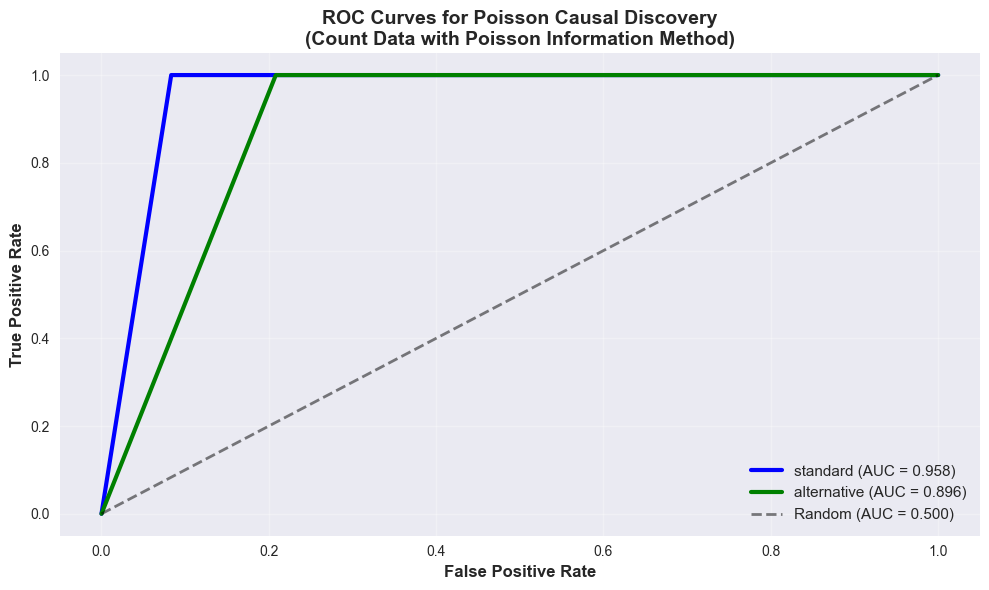


PERFORMANCE SUMMARY - POISSON METHOD
Ground truth edges: 6
Data characteristics: Count data (mean rate ≈ 5.0)
Information method: Poisson (optimal for count data)

Standard method results:
  Discovered edges: 8
  ROC-AUC: 0.958
  Performance: 🟢 Excellent

Alternative method results:
  Discovered edges: 12
  ROC-AUC: 0.896
  Performance: 🟡 Good



In [24]:
def calculate_roc_auc_poisson(true_adj, discovered_graph):
    """Calculate ROC-AUC for Poisson method network discovery."""
    n = true_adj.shape[0]
    
    # Convert discovered graph to adjacency matrix
    G_int = nx.DiGraph()
    G_int.add_nodes_from(range(n))
    for edge in discovered_graph.edges():
        src = int(edge[0].replace('X', '')) if 'X' in str(edge[0]) else int(edge[0])
        dst = int(edge[1].replace('X', '')) if 'X' in str(edge[1]) else int(edge[1])
        G_int.add_edge(src, dst)
    
    discovered_adj = nx.adjacency_matrix(G_int, nodelist=range(n)).toarray()
    
    # Flatten and remove diagonal
    mask = ~np.eye(n, dtype=bool).flatten()
    y_true = true_adj.flatten()[mask]
    y_scores = discovered_adj.flatten()[mask]
    
    # Calculate ROC-AUC
    if len(np.unique(y_true)) > 1:
        auc_score = roc_auc_score(y_true, y_scores)
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        return auc_score, fpr, tpr
    else:
        return None, None, None

# Calculate ROC-AUC for each method
results = {}
plt.figure(figsize=(10, 6))

colors_roc = ['blue', 'green']
for i, (method, G_disc) in enumerate(discovered_networks.items()):
    auc_score, fpr, tpr = calculate_roc_auc_poisson(A_true, G_disc)
    
    if auc_score is not None:
        results[method] = {
            'auc': auc_score,
            'fpr': fpr,
            'tpr': tpr
        }
        
        # Plot ROC curve
        plt.plot(fpr, tpr, color=colors_roc[i], linewidth=3, 
                label=f'{method} (AUC = {auc_score:.3f})')
        
        print(f"{method.upper()} METHOD (Poisson Information):")
        print(f"  ROC-AUC Score: {auc_score:.3f}")
        print(f"  Interpretation: {'Excellent' if auc_score > 0.9 else 'Good' if auc_score > 0.7 else 'Fair' if auc_score > 0.6 else 'Poor'}")
    else:
        print(f"{method} method: Cannot calculate AUC (insufficient variation)")

# Plot random performance line
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Random (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curves for Poisson Causal Discovery\n(Count Data with Poisson Information Method)', 
          fontweight='bold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*55)
print("PERFORMANCE SUMMARY - POISSON METHOD")
print("="*55)
print(f"Ground truth edges: {np.sum(A_true)}")
print(f"Data characteristics: Count data (mean rate ≈ {np.mean(data):.1f})")
print(f"Information method: Poisson (optimal for count data)")
print()
for method, G_disc in discovered_networks.items():
    print(f"{method.capitalize()} method results:")
    print(f"  Discovered edges: {G_disc.number_of_edges()}")
    if method in results:
        print(f"  ROC-AUC: {results[method]['auc']:.3f}")
        print(f"  Performance: {'🟢 Excellent' if results[method]['auc'] > 0.9 else '🟡 Good' if results[method]['auc'] > 0.7 else '🟠 Fair' if results[method]['auc'] > 0.6 else '🔴 Poor'}")
    print()

## 9. Old Poisson Data Generation examples
WIP

In [ ]:
import itertools

def nchoosek(n,k):
    Range = range(1,n+1)
    comb = list(itertools.combinations(Range,k))
    return np.array(comb)

def PermutationMatrix(n):
    p = int(n)
    Zp = int(p*(p-1)/2)
    P = np.zeros((p,Zp))
    NK = nchoosek(p,2)
    for i in range(p):
        Z = np.zeros(Zp)
        Wh = np.where(NK-1==i)
        Z[Wh[0]] = 1;
        P[i,:] = Z
    return P

def Gen_Poisson_Data(A, n=5, Epsilon=1,noiseLevel=1):

    p = int(n)
    noiseLam = noiseLevel*np.ones((p,1))
    Zp = int(p*(p-1)/2)
    lambdas = Epsilon*np.ones((p+Zp,1))
    P = PermutationMatrix(n)
    One_p = np.ones((p,1))
    NK = nchoosek(p,2)
    #Size = (p,p)
    Tr = np.matrix(A[NK[:,0]-1,NK[:,1]-1])
    I_p = np.eye(p)
    T_p = np.dot(One_p,Tr)
    PTP = np.array(P)*np.array(T_p)
    B = np.concatenate((I_p,PTP),axis=1)
    B = B.T
    Lambs = lambdas.T*np.ones((A.T,Zp+p))
    Y = np.random.poisson(Lambs)
    
    Lambs = noiseLam.T*np.ones((A.T,p))
    E = np.random.poisson(Lambs)
    
    X = np.dot(Y,B)+E
    return X

Gen_Poisson_Data(A_true)

In [ ]:
  def Gen_Poisson_Data(self,Epsilon=1,noiseLevel=1):
        if self.NetworkAdjacency is None:
            raise ValueError("Missing adjacency matrix, please add this using set_NetworkAdjacency")
        p = int(self.n)
        noiseLam = noiseLevel*np.ones((p,1))
        Zp = int(p*(p-1)/2)
        lambdas = Epsilon*np.ones((p+Zp,1))
        P = self.PermutationMatrix()
        One_p = np.ones((p,1))
        NK = self.nchoosek(p,2)
        #Size = (p,p)
        Tr = np.matrix(self.NetworkAdjacency[NK[:,0]-1,NK[:,1]-1])
        I_p = np.eye(p)
        T_p = np.dot(One_p,Tr)
        PTP = np.array(P)*np.array(T_p)
        B = np.concatenate((I_p,PTP),axis=1)
        B = B.T
        Lambs = lambdas.T*np.ones((self.T,Zp+p))
        Y = np.random.poisson(Lambs)
        
        Lambs = noiseLam.T*np.ones((self.T,p))
        E = np.random.poisson(Lambs)
        
        X = np.dot(Y,B)+E
        return X
        
    def Gen_Stochastic_Poisson_Pedeli(self,noiseLevel=0):
        """Stochastic Poisson process -
        Structure comes from the paper:
            'Some properties of multivariate INAR(1) processes'
            
        By Pedeli and Karlis
        
        """
           
        if self.NetworkAdjacency is None:
            raise ValueError("Missing adjacency matrix, please add this using set_NetworkAdjacency")
        
        if self.Rho is None:
            raise ValueError("Missing Rho, please set it using set_Rho")
        
        
        p = self.n
        alpha = self.Rho*np.random.rand(p)
        self.PoissonAlphas = alpha
        X = np.zeros((self.T,self.n))
        X.astype('int32')
        T = self.T
        self.T = 1
        X[0,:] = self.Gen_Poisson_Data(noiseLevel=noiseLevel).astype('int32')
        
        for i in range(1,T):
            S = self.Gen_Poisson_Data(noiseLevel=noiseLevel)
            B = np.random.binomial(X[i-1,:].astype('int32'),alpha)
            X[i,:] = B.astype('int32')+S.astype('int32')
            
        self.XY = X
        self.T = T        
    
    def Gen_Stochastic_Poisson_Armillotta(self,Lambda_0=1,Betas=np.array([0.2,0.3,0.2])):
        """Stochastic Poisson process which is generally known as
           an INteger AutoRegressive (INAR) Process from the paper
           on Network INAR or in this case PNAR...   The name of the paper is:
               Poisson network autoregression
               and it is written by Armillotta and Fokianos"""
           
        if self.NetworkAdjacency is None:
            raise ValueError("Missing adjacency matrix, please add this using set_NetworkAdjacency")
        
        if len(Betas)!=3:
            raise ValueError("The Armillotta version of Stochastic Poisson only currently allows for exactly 3 beta values, and thus only allows Tau = 1...")
        beta_0, beta_1, beta_2 = Betas
        A = self.NetworkAdjacency
        self.Armillotta_Poisson_Betas= Betas
        self.Armillotta_Poisson_Lambda_0 = Lambda_0
        Y_init = np.random.poisson(Lambda_0,(self.n,1))
        #To ensure we don't get NaN's do below steps
        D = np.sum(A,axis=1)
        D[np.where(D==0)]=1
        C = A/D
        lam_0 = beta_0 + (beta_1*np.dot(C,Y_init)).T + beta_2*Y_init.T
        X = np.zeros((self.T,self.n))
        X[0,:] = np.random.poisson(lam_0)
        
        for i in range(1,self.T):
            
            lam_t = beta_0 + (beta_1*np.dot(C,X[i-1,:])) + beta_2*X[i-1,:]
            X[i,:] = np.random.poisson(lam_t)
        
        self.XY = X
       